<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/MBIR_JAX_TORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mbirjax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.8/323.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 32.9 MB/s eta 0:00:00


Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Generating Phantom (x)...
Computing Sinogram (y = A*x)...
Starting MBIR Reconstruction...
Iteration 0: Loss = 67117040.000000
Iteration 10: Loss = 54849220.000000
Iteration 20: Loss = 43954072.000000
Iteration 30: Loss = 34422736.000000
Iteration 40: Loss = 26245844.000000
Iteration 50: Loss = 19409832.000000
Iteration 60: Loss = 13892218.000000
Iteration 70: Loss = 9654965.000000
Iteration 80: Loss = 6625168.000000
Iteration 90: Loss = 4646539.000000
Iteration 100: Loss = 3403545.250000
Iteration 110: Loss = 2536799.000000
Iteration 120: Loss = 1885003.000000
Iteration 130: Loss = 1391037.625000
Iteration 140: Loss = 1014562.125000
Iteration 150: Loss = 726200.312500
Iteration 160: Loss = 506015.843750
Iteration 170: Loss = 339850.156250
Iteration 180: Loss = 217079.859375
Iteration 190: Loss = 129276.3

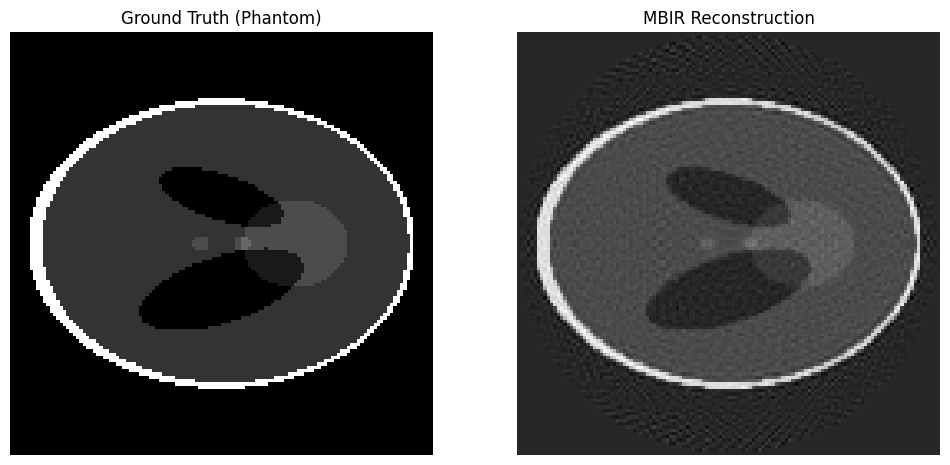

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mbirjax

# Define parameters for sinogram
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = 'parallel'

# Define projection angles
start_angle = -np.pi / 2
end_angle = np.pi / 2
angles = torch.linspace(start_angle, end_angle, num_views)

# Initialize MBIR-JAX model
sinogram_shape = (num_views, num_det_rows, num_det_channels)
ct_model = mbirjax.ParallelBeamModel(sinogram_shape, angles.numpy())

# Generate Shepp-Logan phantom
print("Generating Phantom (x)...")
true_image = torch.tensor(np.array(ct_model.gen_modified_3d_sl_phantom()), dtype=torch.float32).clone()

# Compute forward projection (A*x = y)
print("Computing Sinogram (y = A*x)...")
y = torch.tensor(np.array(ct_model.forward_project(true_image.numpy())), dtype=torch.float32).clone()


# **MBIR-Based Iterative Reconstruction**
num_iterations = 1000  # Iteration count
learning_rate = 1  # Learning rate

# Initialize reconstructed image with zeros
x = torch.zeros_like(true_image)

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    Ax = torch.tensor(np.array(ct_model.forward_project(x.numpy())), dtype=torch.float32).clone()  # Compute Ax (forward projection)
    residual = y - Ax  # Compute (y - Ax)

    # Compute loss ||y - Ax||^2
    loss = torch.norm(residual) ** 2

    # Compute gradient: Aᵀ(y - Ax) (back-projection step)
    gradient = torch.tensor(np.array(ct_model.back_project(residual.numpy())), dtype=torch.float32).clone()

    # Normalize gradient to avoid large updates
    gradient = gradient / (torch.max(torch.abs(gradient)) + 1e-6)

    # Adaptive step size to avoid divergence
    step_size = learning_rate / (torch.norm(gradient) + 1e-6)

    # Update x using gradient descent
    x = x + step_size * gradient

    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss:.6f}")

# Convert to NumPy for visualization
mbir_reconstruction = x.numpy()

# Display Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(true_image.numpy()[:, :, true_image.shape[2] // 2], cmap='gray')
plt.title("Ground Truth (Phantom)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mbir_reconstruction[:, :, mbir_reconstruction.shape[2] // 2], cmap='gray')
plt.title("MBIR Reconstruction")
plt.axis("off")

plt.show()

Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Generating Phantom (x)...
Computing Sinogram (y = A*x)...
Starting MBIR Reconstruction...
Iteration 0: Loss = 66950964.000000
Iteration 10: Loss = 65664092.000000
Iteration 20: Loss = 64390992.000000
Iteration 30: Loss = 63131636.000000
Iteration 40: Loss = 61886040.000000
Iteration 50: Loss = 60654184.000000
Iteration 60: Loss = 59436060.000000
Iteration 70: Loss = 58231684.000000
Iteration 80: Loss = 57041040.000000
Iteration 90: Loss = 55864108.000000
Iteration 100: Loss = 54700904.000000
Iteration 110: Loss = 53551408.000000
Iteration 120: Loss = 52415628.000000
Iteration 130: Loss = 51293536.000000
Iteration 140: Loss = 50185152.000000
Iteration 150: Loss = 49090448.000000
Iteration 160: Loss = 48009436.000000
Iteration 170: Loss = 46942088.000000
Iteration 180: Loss = 45888424.000000
Iteration 190:

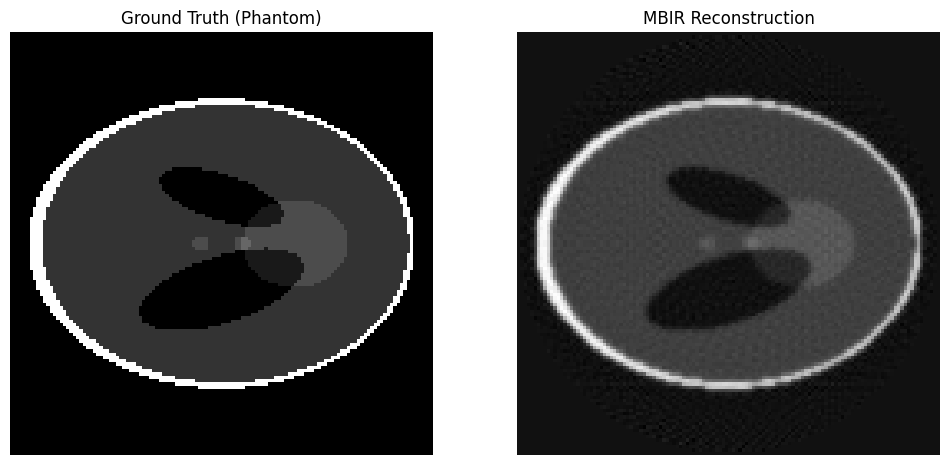

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import mbirjax
import matplotlib.pyplot as plt

# Define parameters for sinogram
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = 'parallel'

# Define projection angles
start_angle = -np.pi / 2
end_angle = np.pi / 2
angles = jnp.linspace(start_angle, end_angle, num_views, endpoint=False)

# Initialize MBIR-JAX model
sinogram_shape = (num_views, num_det_rows, num_det_channels)
ct_model = mbirjax.ParallelBeamModel(sinogram_shape, angles)

# Generate Shepp-Logan phantom
print("Generating Phantom (x)...")
true_image = ct_model.gen_modified_3d_sl_phantom()

# Compute forward projection (A*x = y)
print("Computing Sinogram (y = A*x)...")
y = ct_model.forward_project(true_image)  # Forward projection, Ax



# **MBIR-Based Iterative Reconstruction**
num_iterations = 2000  # Iteration count
learning_rate = 0.1  # Learning rate

# Initialize reconstructed image with zeros
x = jnp.zeros_like(true_image)

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    Ax = ct_model.forward_project(x)  # Compute Ax (forward projection)
    residual = y - Ax  # Compute (y - Ax)

    # Compute loss ||y - Ax||^2
    loss = jnp.linalg.norm(residual) ** 2

    # Compute gradient: Aᵀ(y - Ax) (back-projection step)
    gradient = ct_model.back_project(residual)

    # Normalize gradient to avoid large updates
    gradient = gradient / (jnp.max(jnp.abs(gradient)) + 1e-6)

    # Adaptive step size to avoid divergence
    step_size = learning_rate / (jnp.linalg.norm(gradient) + 1e-6)

    # Update x using gradient descent
    x = x + step_size * gradient

    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss:.6f}")

# Convert to NumPy for visualization
mbir_reconstruction = np.array(x)

# Display Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(true_image[:, :, true_image.shape[2] // 2], cmap='gray')
plt.title("Ground Truth (Phantom)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mbir_reconstruction[:, :, mbir_reconstruction.shape[2] // 2], cmap='gray')
plt.title("MBIR Reconstruction")
plt.axis("off")

plt.show()
